In [3]:
import numpy as np
# 对图像进行归一化并调整亮度
def normalize_and_adjust_brightness(image, brightness_factor=3):
    img_max = np.max(np.abs(image))
    img_norm = np.abs(image) / img_max
    img_brightened = np.clip(img_norm * brightness_factor, 0, 1)
    return img_brightened



k_cine_data_test: (118, 20, 18, 192, 192)
(24, 192, 192, 18) (24, 192, 192, 18) (24, 1, 192, 192, 18) (24, 1, 192, 192, 18)
complex64 complex64 complex64 complex64
k_cine_data_test_t-dtype: complex64


/data0/zhiyong/software/Anaconda3_2024/envs/k_gin_zzy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data0/zhiyong/software/Anaconda3_2024/envs/k_gin_zzy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


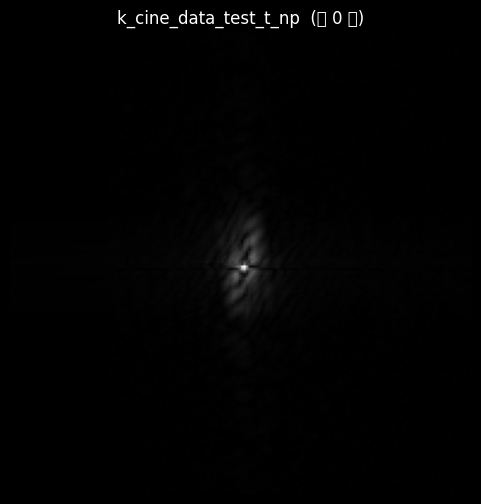

k_cine_data_test_shift-dtype: complex64


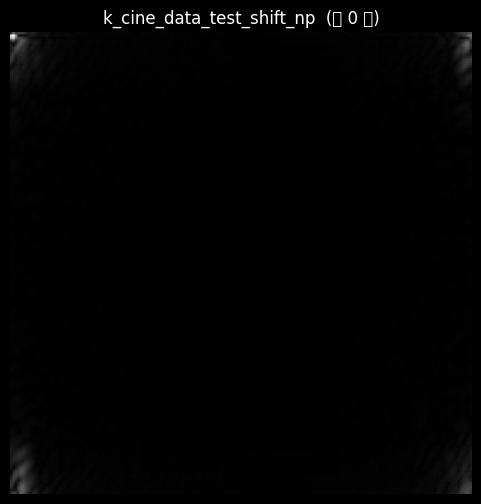

img_k_cine_data_test_t-dtype: complex128


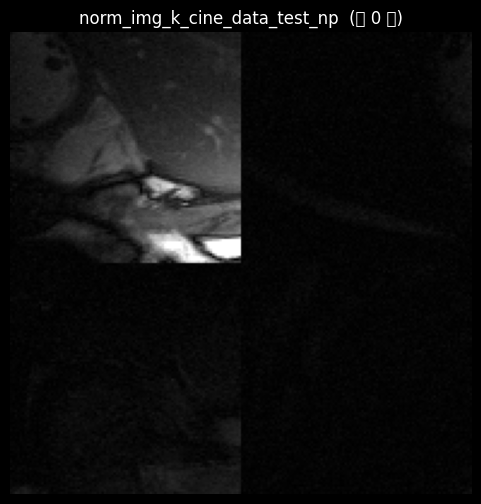

img_k_cine_data_test_shift-dtype: complex128


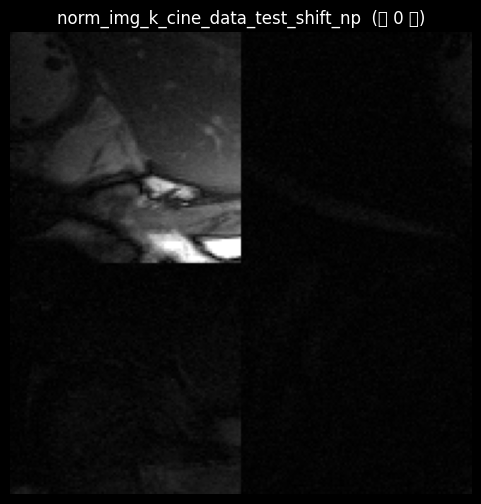

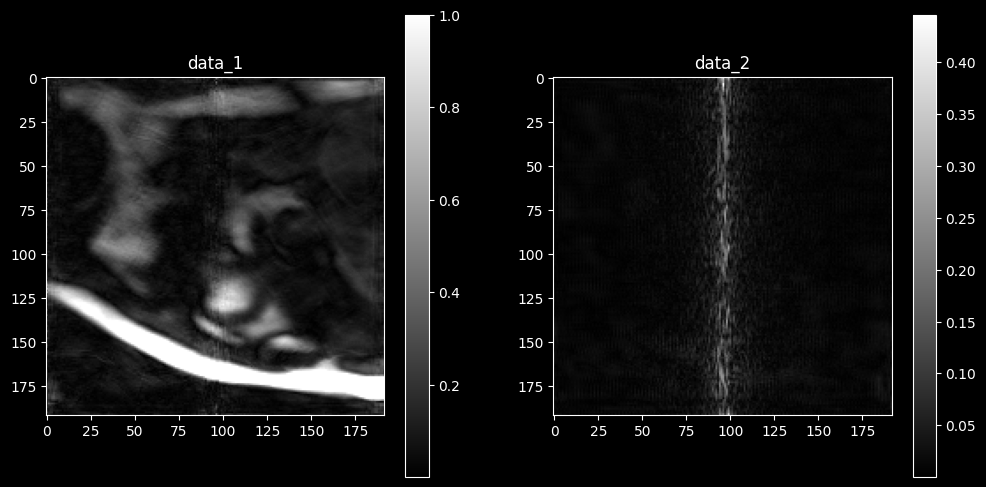

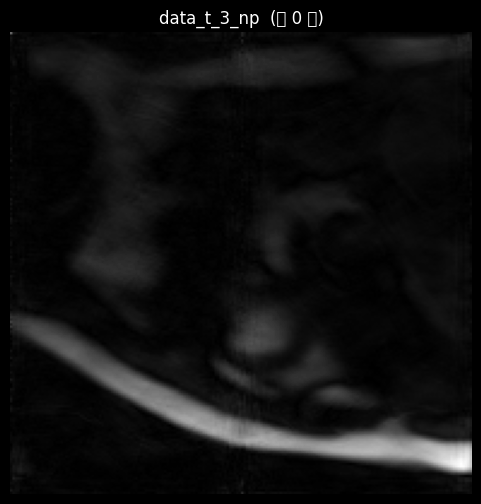

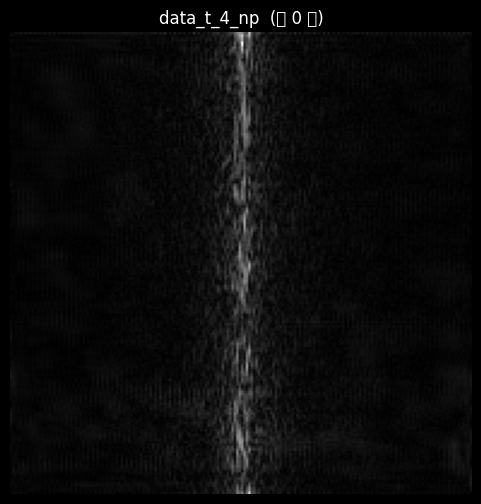

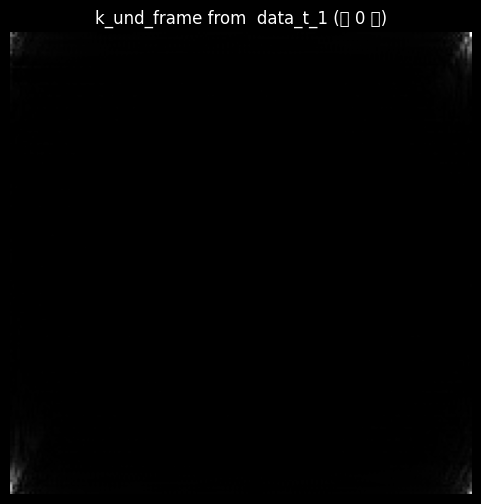

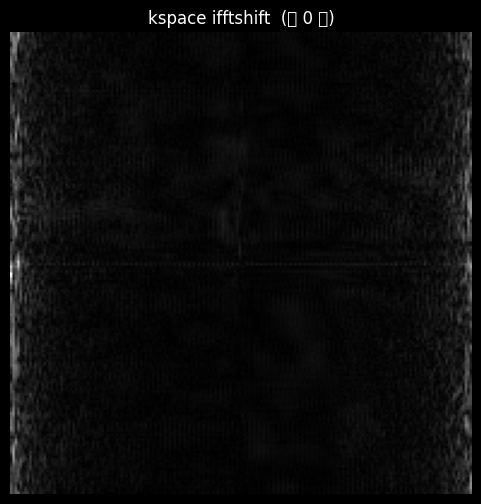

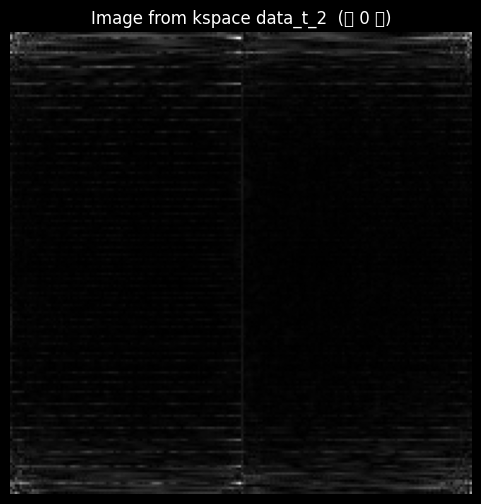

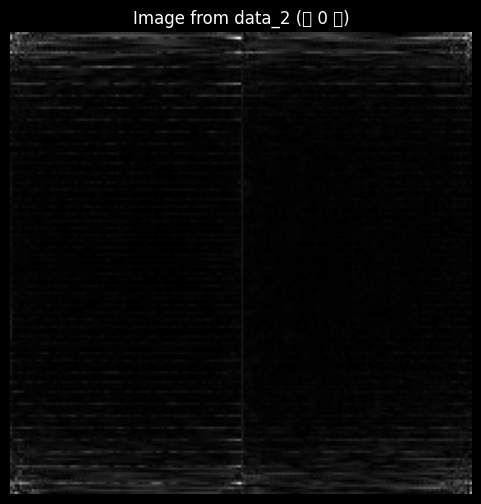

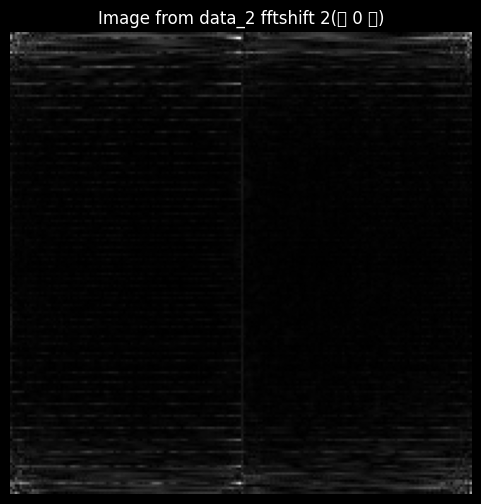

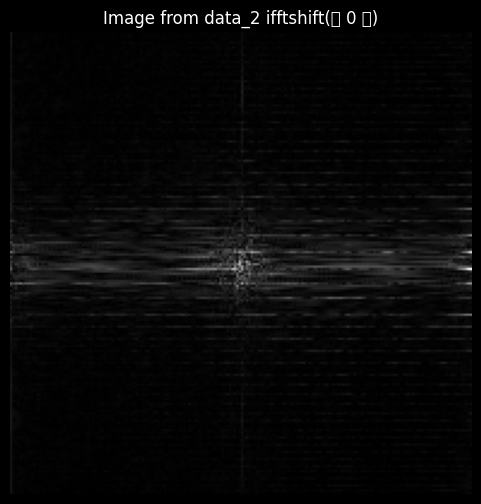

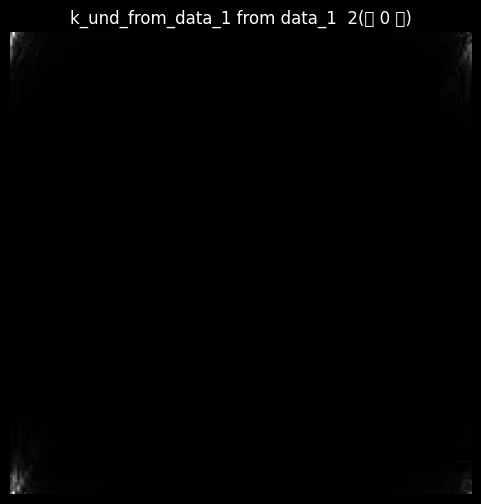

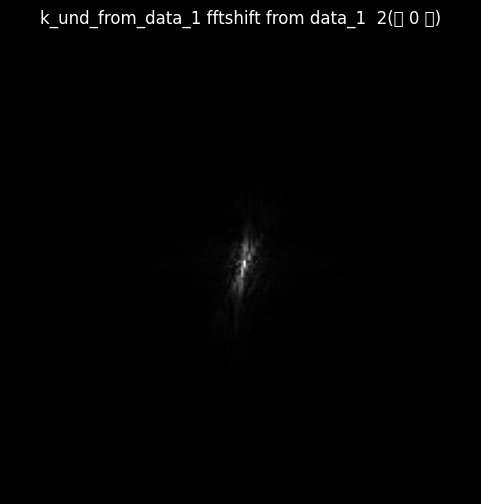

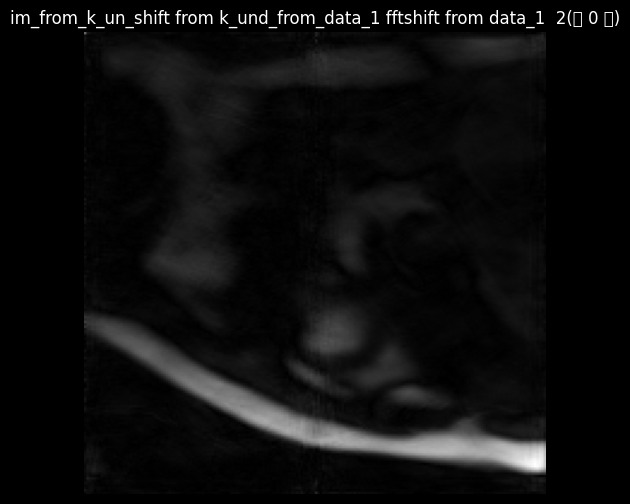

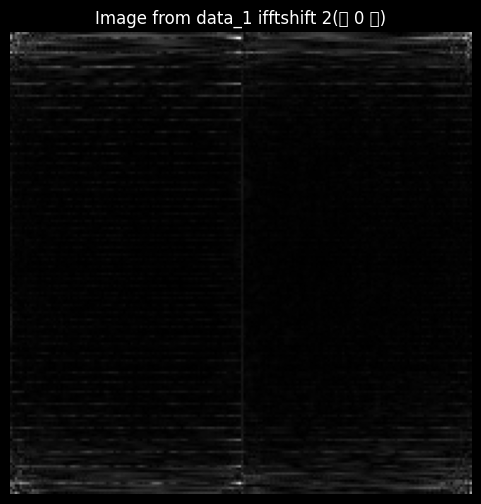

In [6]:
import os
# import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat
from os.path import join
from utils import compressed_sensing as cs
# from cascadenet_pytorch.dnn_io import to_tensor_format, from_tensor_format

'''
跑100个epoch的结果:
Epoch 101/100
 time: 52.61929655075073s
 training loss:		0.018023
 testing loss:		0.001912
 base PSNR:		19.928110
 test PSNR:		24.175289
model parameters saved at ./models/model_epoch_100.npz
'''

##我们的数据
k_cine_file_path_test = '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy'
# file_path_1 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_test_run_test_0228_3/im_recon.npy'
file_path_1 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_vista_test_run_test_0301_5/im_recon.npy'
#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_rec_epoch200.npy
file_path_2 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_vista_test_run_test_0301_5/ksapce_recon.npy'
file_path_3 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_vista_test_run_test_0301_5/im_recon_list.npy'
file_path_4 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_vista_test_run_test_0301_5/ksapce_recon_list.npy'
file_path_mask = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_vista_test_run_test_0301_5/ksapce_recon_list.npy'
# Read the files
k_cine_data_test = np.load(k_cine_file_path_test)
# k_cine_data_test = np.load('/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy')
# (118, 20, 18, 192, 192)
# print(k_cine_data_test.shape)

data_1 = np.load(file_path_1)
data_2 = np.load(file_path_2)
data_3 = np.load(file_path_3)
data_4 = np.load(file_path_4)



# Get the dimensions of the data
# our_data_test_dim = our_data_test.shape
dimensions_1 = data_1.shape
dimensions_2 = data_2.shape
dimensions_3 = data_3.shape
dimensions_4 = data_4.shape

print('k_cine_data_test:',k_cine_data_test.shape) #(118, 20, 18, 192, 192)
#(24, 192, 192, 18) (24, 192, 192, 18) (24, 1, 192, 192, 18) (24, 1, 192, 192, 18)
print(dimensions_1, dimensions_2,dimensions_3,dimensions_4) #(24, 2, 192, 192, 18) (1, 30, 256, 256) (1, 30, 256, 256)
# print(our_file_path_test.dtype)
#complex64 complex64 complex64 complex64
print(data_1.dtype,data_2.dtype,data_3.dtype,data_4.dtype)

##通过下面的代码知道我们的数据ksapce低频在中心
k_cine_data_test_t = k_cine_data_test[0,0,0,:,:]
print('k_cine_data_test_t-dtype:',k_cine_data_test_t.dtype)
k_cine_data_test_t_np = np.abs(k_cine_data_test_t)  # 取模
# 显示kspace的数据 低频kspace位于中心
plt.figure(figsize=(6, 6))
plt.imshow(k_cine_data_test_t_np, cmap='gray')  # 使用灰度颜色映射
plt.title("k_cine_data_test_t_np  (第 0 帧)")
plt.axis('off')
plt.show()

k_cine_data_test_shift = np.fft.fftshift(k_cine_data_test_t)
print('k_cine_data_test_shift-dtype:',k_cine_data_test_shift.dtype)
k_cine_data_test_shift_np = np.abs(k_cine_data_test_shift)  # 取模
# 显示kspace的数据 shift之后低频kspace位于四个角
plt.figure(figsize=(6, 6))
plt.imshow(k_cine_data_test_shift_np, cmap='gray')  # 使用灰度颜色映射
plt.title("k_cine_data_test_shift_np  (第 0 帧)")
plt.axis('off')
plt.show()

img_k_cine_data_test_t = np.fft.ifft2(k_cine_data_test_t)
print('img_k_cine_data_test_t-dtype:',img_k_cine_data_test_t.dtype)
norm_img_k_cine_data_test =  normalize_and_adjust_brightness(img_k_cine_data_test_t)
norm_img_k_cine_data_test_np = np.abs(norm_img_k_cine_data_test)  # 取模
# 显示kspace的数据 shift之后低频kspace位于四个角
plt.figure(figsize=(6, 6))
plt.imshow(norm_img_k_cine_data_test_np, cmap='gray')  # 使用灰度颜色映射
plt.title("norm_img_k_cine_data_test_np  (第 0 帧)")
plt.axis('off')
plt.show()

img_k_cine_data_test_shift= np.fft.ifft2(k_cine_data_test_shift)
print('img_k_cine_data_test_shift-dtype:',img_k_cine_data_test_shift.dtype)
norm_img_k_cine_data_test_shift =  normalize_and_adjust_brightness(img_k_cine_data_test_shift)
norm_img_k_cine_data_test_shift_np = np.abs(norm_img_k_cine_data_test_shift)  # 取模
# 显示kspace的数据 shift之后低频kspace位于四个角
plt.figure(figsize=(6, 6))
plt.imshow(norm_img_k_cine_data_test_shift_np, cmap='gray')  # 使用灰度颜色映射
plt.title("norm_img_k_cine_data_test_shift_np  (第 0 帧)")
plt.axis('off')
plt.show()


# data_t_1 = data_1[0,0,:,:]
data_t_1 = data_1[0,:,:,0]
data_t_2 = data_2[0,:,:,0]
data_t_3 = data_3[0,0,:,:,0]
data_t_4 = data_4[0,0,:,:,0]

# Displaying the first slice of the first channel for both data1 and data2
plt.figure(figsize=(12, 6))

# For data1 (complex), we can show the magnitude
norm_data_t_1 = normalize_and_adjust_brightness(data_t_1)
plt.subplot(1, 2, 1)
# plt.imshow(np.abs(data_t_1), cmap='gray')
plt.imshow(np.abs(norm_data_t_1), cmap='gray')
plt.title('norm_data_t_1')
plt.colorbar()

# For data2 (float), we can show the data directly
plt.subplot(1, 2, 2)
# plt.imshow(data_2[0, 0], cmap='gray')
plt.imshow(np.abs(data_t_2), cmap='gray')
plt.title('data_2')
plt.colorbar()
plt.show()

data_t_3_np = np.abs(data_t_3)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(data_t_3_np, cmap='gray')  # 使用灰度颜色映射
plt.title("data_t_3_np  (第 0 帧)")
plt.axis('off')
plt.show()

data_t_4_np = np.abs(data_t_4)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(data_t_4_np, cmap='gray')  # 使用灰度颜色映射
plt.title("data_t_4_np  (第 0 帧)")
plt.axis('off')
plt.show()

im_und_frame = data_t_1 # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
k_und_frame = np.fft.ifft2(im_und_frame)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(k_und_frame)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("k_und_frame from  data_t_1 (第 0 帧)")
plt.axis('off')
plt.show()


k_und_frame = data_t_2 # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
k_und_frame = np.fft.ifftshift(k_und_frame)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(k_und_frame)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("kspace ifftshift  (第 0 帧)")
plt.axis('off')
plt.show()

# k_und_frame = data_1[0,0,:,:]  # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
# im_from_k_und = np.fft.ifft2(k_und_frame)  # 逆傅里叶变换
im_from_k_und = np.fft.ifft2(data_t_2)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from kspace data_t_2  (第 0 帧)")
plt.axis('off')
plt.show()

# 假设 k_und_from_im 是 k-space 数据，形状为 [256, 256]
# 如果 k_und_from_im 是 3D 数据（例如 [256, 256, 30]），需要选择特定的帧
k_und_frame = data_t_2  # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und = np.fft.ifft2(k_und_frame)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_2 (第 0 帧)")
plt.axis('off')
plt.show()

k_und_frame_2 = np.fft.fftshift(data_t_2)  # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und_2 = np.fft.ifft2(k_und_frame_2)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude_2 = np.abs(im_from_k_und_2)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_2 fftshift 2(第 0 帧)")
plt.axis('off')
plt.show()

# 假设 k_und_from_im 是 k-space 数据，形状为 [256, 256]
# 如果 k_und_from_im 是 3D 数据（例如 [256, 256, 30]），需要选择特定的帧
# k_und_frame = data_1[0,0,:,:]  # 选择第 0 帧（如果是 3D 数据）
# k_und_from_im_center = np.fft.fftshift(data_1[0,0,:,:])
# k_und_from_im = np.fft.ifftshift(data_1[0,0,:,:])
k_und_from_im = data_t_2
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und = np.fft.ifft2(k_und_from_im)  # 逆傅里叶变换
im_from_k_und = np.fft.fftshift(im_from_k_und)
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_2 ifftshift(第 0 帧)")
plt.axis('off')
plt.show()


# k_und_from_im = data_1[0,0,:,:]
# 重建图片转到kspace 发现kspace在四个角
k_und_from_data_1 = np.fft.fft2(data_t_1)  # 逆傅里叶变换
# im_from_k_und = np.fft.fftshift(im_from_k_und)
# 计算图像域数据的幅值
im_magnitude = np.abs(k_und_from_data_1)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("k_und_from_data_1 from data_1  2(第 0 帧)")
plt.axis('off')
plt.show()

# 对 k-space 数据进行逆傅里叶变换，转换回图像域
k_und_from_data_1 = np.fft.fft2(data_t_1)  # 逆傅里叶变换
k_und_from_data_1 = np.fft.fftshift(k_und_from_data_1)
# 计算图像域数据的幅值
im_magnitude = np.abs(k_und_from_data_1)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("k_und_from_data_1 fftshift from data_1  2(第 0 帧)")
plt.axis('off')
plt.show()

k_und_from_data_1 = np.fft.fft2(data_t_1)  # 逆傅里叶变换
k_und_from_data_1 = np.fft.fftshift(k_und_from_data_1)
im_from_k_un_shift = np.fft.ifft2(k_und_from_data_1)
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_un_shift)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("im_from_k_un_shift from k_und_from_data_1 fftshift from data_1  2(第 0 帧)")
plt.axis('off')
plt.show()



# im_from_k_und = np.fft.fft2(im_from_k_und)  # 逆傅里叶变换
im_from_k_und = np.fft.fftshift(im_from_k_und)
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_1 ifftshift 2(第 0 帧)")
plt.axis('off')
plt.show()

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat
from os.path import join
from utils import compressed_sensing as cs
# from cascadenet_pytorch.dnn_io import to_tensor_format, from_tensor_format

'''
跑100个epoch的结果:
Epoch 101/100
 time: 52.61929655075073s
 training loss:		0.018023
 testing loss:		0.001912
 base PSNR:		19.928110
 test PSNR:		24.175289
model parameters saved at ./models/model_epoch_100.npz
'''
# Load the .npy files
# file_path_1 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0223_2/last_epoch_k.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0223_2/last_epoch_k_image.npy"
# file_path_1 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0223_2/last_epoch_k0.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0223_2/last_epoch_k0_image.npy"
# file_path_1 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0223_3/last_epoch_k.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0223_3/last_epoch_k_image.npy"

#/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_1/last_epoch_k_image.npy
# file_path_1 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_2/last_epoch_k.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_2/last_epoch_k_image.npy"
# file_path_1 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_3/last_epoch_k.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_3/last_epoch_k_image.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_6/last_epoch_k_image.npy"
# file_path_1 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_1/last_epoch_out.npy"
# file_path_2 = "/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_1/last_epoch_out_image.npy"

# file_path_1 = '/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_6/last_epoch_x_recon_image.npy'
# file_path_1 = '/nfs/zzy/code/Deep-MRI-Reconstruction/saved_data/0224_3/last_epoch_out_image.npy'

#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_gnd_epoch100.npy
#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_gnd_epoch100.png

#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_rec_epoch100.npy
#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_rec_epoch100.png


#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_und_epoch100.npy
#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_und_epoch100.png

# file_path_1 = '/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_gnd_epoch500.npy'
# file_path_2 = '/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_gnd_epoch100.png'
# file_path_2 = '/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_rec_epoch100.npy'

# file_path_1 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_test_run_test_0228_3/im_recon.npy'
#/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_rec_epoch200.npy
# file_path_2 = '/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_rec_epoch500.npy'
# file_path_3 = '/data0/zhiyong/code/github/kt-Dynamic-MRI-Reconstruction/results/im_und_epoch500.npy'
file_path_1 = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/models/runs/kt_next_vista_test_run_test_0301_5/im_recon.npy'
file_path_2 = ''
file_path_3 = ''
file_path_4 = ''
file_path_mask = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/masks/VISTA/samp_VISTA_192x18_R4.mat'
# Read the files
data_1 = np.load(file_path_1)
data_2 = np.load(file_path_2)
data_3 = np.load(file_path_3)



# Get the dimensions of the data
dimensions_1 = data_1.shape
dimensions_2 = data_2.shape
dimensions_3 = data_3.shape


print(dimensions_1, dimensions_2,dimensions_3) #(24, 2, 192, 192, 18) (1, 30, 256, 256) (1, 30, 256, 256)
print(data_1.dtype,data_2.dtype,data_3.dtype) #float32 complex64 complex64

# data_t_1 = data_1[0,0,:,:]
data_t_1 = data_1[0,0,:,:,0]
data_t_2 = data_2[0,0,:,:]
data_t_3 = data_3[0,0,:,:]

# Displaying the first slice of the first channel for both data1 and data2
plt.figure(figsize=(12, 6))

# For data1 (complex), we can show the magnitude
plt.subplot(1, 2, 1)
plt.imshow(np.abs(data_t_1), cmap='gray')
plt.title('im_gnd_epoch500')
plt.colorbar()

# For data2 (float), we can show the data directly
plt.subplot(1, 2, 2)
# plt.imshow(data_2[0, 0], cmap='gray')
plt.imshow(np.abs(data_t_2), cmap='gray')
plt.title('im_rec_epoch500')
plt.colorbar()
plt.show()

data_t_3_np = np.abs(data_t_3)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(data_t_3_np, cmap='gray')  # 使用灰度颜色映射
plt.title("im_und_epoch500  (第 0 帧)")
plt.axis('off')
plt.show()

k_und_frame = data_t_1 # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
k_und_frame = np.fft.ifftshift(k_und_frame)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(k_und_frame)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("kspace ifftshift  (第 0 帧)")
plt.axis('off')
plt.show()

# k_und_frame = data_1[0,0,:,:]  # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und = np.fft.ifft2(k_und_frame)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from kspace ifftshift  (第 0 帧)")
plt.axis('off')
plt.show()

# 假设 k_und_from_im 是 k-space 数据，形状为 [256, 256]
# 如果 k_und_from_im 是 3D 数据（例如 [256, 256, 30]），需要选择特定的帧
k_und_frame = data_t  # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und = np.fft.ifft2(k_und_frame)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_1 (第 0 帧)")
plt.axis('off')
plt.show()

k_und_frame_2 = np.fft.fftshift(data_t)  # 选择第 0 帧（如果是 3D 数据）
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und_2 = np.fft.ifft2(k_und_frame_2)  # 逆傅里叶变换
# 计算图像域数据的幅值
im_magnitude_2 = np.abs(im_from_k_und_2)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_1 fftshift 2(第 0 帧)")
plt.axis('off')
plt.show()

# 假设 k_und_from_im 是 k-space 数据，形状为 [256, 256]
# 如果 k_und_from_im 是 3D 数据（例如 [256, 256, 30]），需要选择特定的帧
# k_und_frame = data_1[0,0,:,:]  # 选择第 0 帧（如果是 3D 数据）
# k_und_from_im_center = np.fft.fftshift(data_1[0,0,:,:])
# k_und_from_im = np.fft.ifftshift(data_1[0,0,:,:])
k_und_from_im = data_t
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und = np.fft.ifft2(k_und_from_im)  # 逆傅里叶变换
im_from_k_und = np.fft.fftshift(im_from_k_und)
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_1 ifftshift(第 0 帧)")
plt.axis('off')
plt.show()


# k_und_from_im = data_1[0,0,:,:]
# 对 k-space 数据进行逆傅里叶变换，转换回图像域
im_from_k_und = np.fft.fft2(im_from_k_und)  # 逆傅里叶变换
# im_from_k_und = np.fft.fftshift(im_from_k_und)
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_1 ifftshift 2(第 0 帧)")
plt.axis('off')
plt.show()


# im_from_k_und = np.fft.fft2(im_from_k_und)  # 逆傅里叶变换
im_from_k_und = np.fft.fftshift(im_from_k_und)
# 计算图像域数据的幅值
im_magnitude = np.abs(im_from_k_und)  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(im_magnitude, cmap='gray')  # 使用灰度颜色映射
plt.title("Image from data_1 ifftshift 2(第 0 帧)")
plt.axis('off')
plt.show()

## 显示vista mask

mask-shape: (18, 192, 192)
mask_all-shape-1: (18, 192, 192)
mask-shape-1: (18, 192)
mask-shape-2: (192, 192)
mask-shape-3: (192, 192)


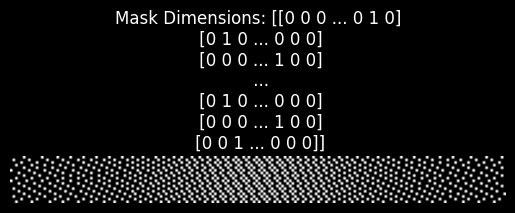

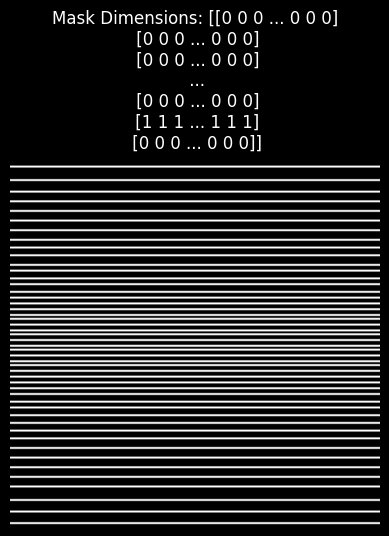

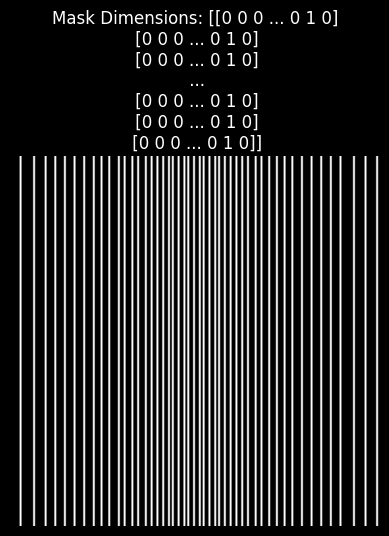

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 加载 .mat 文件
file_path_mask = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/masks/VISTA/samp_VISTA_192x18_R4.mat'
mask_data = scipy.io.loadmat(file_path_mask)
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 加载 .mat 文件
filepath = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/masks/VISTA/samp_VISTA_192x18_R4.mat'
mask_data = scipy.io.loadmat(filepath)
# mask = mask_data['mask'][:, :, 0].astype(np.int32)
mask = mask_data['mask'].astype(np.int32) 
print('mask-shape:',mask.shape) #mask-shape: (18, 192, 192)
mask_all = mask_data['mask'][:].astype(np.int32) 
print('mask_all-shape-1:',mask_all.shape) #mask_all-shape-1: (18, 192, 192)

mask_1 = mask[:,:,0]
print('mask-shape-1:',mask_1.shape) #mask-shape-1: (18, 192)

mask_2 = mask[0,:,:]
print('mask-shape-2:',mask_2.shape) #mask-shape-2: (192, 192)

mask_3 = np.transpose(mask_2,[1,0])
print('mask-shape-3:',mask_3.shape) #mask-shape-2: (192, 192)



# # 遍历所有键，找到数组数据
# for key in mask_data.keys():
#     if isinstance(mask_data[key], np.ndarray):
#         mask = mask_data[key]
#         mask_dimensions = mask.shape
#         print(f"Key: {key}, Mask Dimensions: {mask_dimensions}") #Key: mask, Mask Dimensions: (18, 192, 192)

#         # 以图片形式显示 mask
#         plt.imshow(mask[0,:,:], cmap='gray')
#         plt.title(f"Key: {key}, Mask Dimensions: {mask_dimensions}")
#         plt.axis('off')  # 关闭坐标轴数字
#         plt.show()

# # 检查 mask 的维度
# mask_keys = list(mask_data.keys())
# mask = mask_data[mask_keys[0]]  # 假设第一个键包含 mask 数据
# mask_dimensions = mask.shape

# 显示 mask 的维度
# print("Mask Dimensions:", mask_dimensions)

# 以图片形式显示 mask
plt.imshow(mask_1, cmap='gray')
plt.title(f"Mask Dimensions: {mask_1}")
plt.axis('off')  # 关闭坐标轴数字
plt.show()

# 以图片形式显示 mask
plt.imshow(mask_2, cmap='gray')
plt.title(f"Mask Dimensions: {mask_2}")
plt.axis('off')  # 关闭坐标轴数字
plt.show()

# 以图片形式显示 mask
plt.imshow(mask_3, cmap='gray')
plt.title(f"Mask Dimensions: {mask_3}")
plt.axis('off')  # 关闭坐标轴数字
plt.show()
